Скачайте датасет и проведите RFM анализ. В каждом подсегменте поделите пользователей на 4 класса (как на занятии). Отсчитывайте количество дней, прошедших с момента последней покупки, с максимальной даты покупки в датасете.

1. Какое максимальное кол-во покупок было совершено одним пользователем?
2. Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)
3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?
4. Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?
5. Сколько пользователей попало в сегмент 111?
6. Сколько пользователей попало в сегмент 311?
7. В каком RFM-сегменте самое большое кол-во пользователей?
8. В каком RFM-сегменте самое маленькое кол-во пользователей?
9. Какое количество пользователей попало в самый малочисленный сегмент?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
import datetime as dt
%matplotlib inline 
import calendar

In [2]:
df = pd.read_csv('./RFM_ht_data.csv', parse_dates=['InvoiceDate'], dtype={"InvoiceNo": str, "CustomerCode": str, "Amount": "float64"})

In [3]:
df.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [4]:
df.dtypes

InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object

In [5]:
last_date = df.InvoiceDate.max()
last_date

Timestamp('2020-09-30 00:00:00')

In [6]:
df.columns

Index(['InvoiceNo', 'CustomerCode', 'InvoiceDate', 'Amount'], dtype='object')

In [7]:
rename_columns = {}
for col in df.columns:
    rename_columns[col] = col.lower()

In [8]:
df = df.rename(columns=rename_columns)
df.head(2)

,invoiceno,customercode,invoicedate,amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74


In [9]:
df = df.rename(columns={
    'invoiceno':'invoice_no',
    'customercode' : 'customer_code',
    'invoicedate' : 'invoice_date',
    'amount':'amount'})

df.head()

,invoice_no,customer_code,invoice_date,amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00


In [10]:
rfm_df = df.groupby(by='customer_code', as_index=False) \
    .agg(
        {
            'invoice_date': lambda x: (last_date - x.max()).days, # Recency 
            'invoice_no': len, # Frequency
            'amount': 'sum' # Monetary
        } 
    )

In [11]:
rfm_df

,customer_code,invoice_date,invoice_no,amount
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


In [12]:
rfm_df = rfm_df.rename(columns={
    'invoice_date':'recency',
    'invoice_no' : 'frequency',
    'amount':'monetary'})

rfm_df.head()

,customer_code,recency,frequency,monetary
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88


In [13]:
df_quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
df_quantiles

C:\Users\Ann Zalivatskaya\AppData\Local\Temp\ipykernel_16224\423560410.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])


,recency,frequency,monetary
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


<Axes: xlabel='recency', ylabel='Count'>

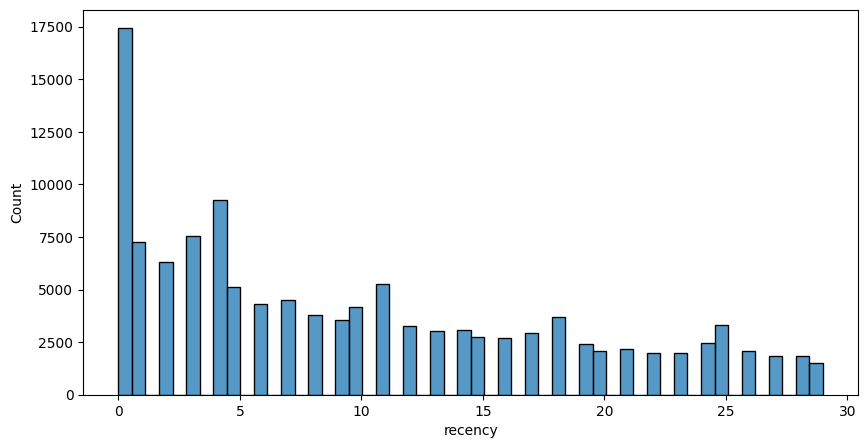

In [14]:
plt.figure(figsize=(10,5))
sns.histplot(rfm_df.recency) #распределение "recency" 

In [14]:
def R(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4


def FM(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

In [15]:
rfm_df['r'] = rfm_df.recency.apply(R, args=('recency', df_quantiles))
rfm_df['f'] = rfm_df.frequency.apply(FM, args=('frequency', df_quantiles))
rfm_df['m'] = rfm_df.monetary.apply(FM, args=('monetary', df_quantiles))

In [16]:
rfm_df

,customer_code,recency,frequency,monetary,r,f,m
0,02213019,19,1,1609.20,4,4,3
1,02213042,22,3,9685.48,4,2,1
2,02213071,29,1,415.00,4,4,4
3,02213088,23,1,305.00,4,4,4
4,02213092,25,1,1412.88,4,4,3
...,...,...,...,...,...,...,...
123728,99099927,10,1,961.10,3,4,3
123729,99099936,0,1,1521.78,1,4,3
123730,99099959,8,2,1444.56,2,3,3
123731,99099963,19,1,3018.91,4,4,2


In [17]:
rfm_df['RFM_Score'] = rfm_df.r.map(str) + rfm_df.f.map(str) + rfm_df.m.map(str)

rfm_df.head()

,customer_code,recency,frequency,monetary,r,f,m,RFM_Score
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443


# Задание 1
Какое максимальное кол-во покупок было совершено одним пользователем?

In [18]:
df_invoices = df.groupby(by='customer_code', as_index=False) \
    .agg({'invoice_no':'count'}) \
    .sort_values(by='invoice_no', ascending=False) \
    .rename(columns={'invoice_no':'invoice_counts'})

df_invoices.head()

,customer_code,invoice_counts
89388,19057820,204
44594,13215452,113
10347,13032521,106
97077,19080880,99
119951,99003061,90


Ответ:

In [19]:
df_invoices[df_invoices.invoice_counts == df_invoices.invoice_counts.max()]

,customer_code,invoice_counts
89388,19057820,204


# Задание 2
Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)

In [20]:
rfm_df.monetary.quantile(q=[0.25,0.5,0.75])

0.25     765.00
0.50    1834.48
0.75    4008.84
Name: monetary, dtype: float64

Ответ: 765

#  Задание 3
Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?

In [21]:
rfm_df.frequency.quantile(q=[0.25,0.5,0.75])

0.25    1.0
0.50    2.0
0.75    3.0
Name: frequency, dtype: float64

In [22]:
rfm_df.query('frequency > 3').min()

customer_code    02213129
recency                 0
frequency               4
monetary            265.0
r                       1
f                       1
m                       1
RFM_Score             111
dtype: object

Ответ: 4

# Задание 4
Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?

In [23]:
rfm_df.recency.quantile(q=[0.25,0.5,0.75])

0.25     2.0
0.50     8.0
0.75    16.0
Name: recency, dtype: float64

Ответ: 8

# Задание 5
Сколько пользователей попало в сегмент 111?

In [24]:
rfm_df

,customer_code,recency,frequency,monetary,r,f,m,RFM_Score
0,02213019,19,1,1609.20,4,4,3,443
1,02213042,22,3,9685.48,4,2,1,421
2,02213071,29,1,415.00,4,4,4,444
3,02213088,23,1,305.00,4,4,4,444
4,02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...,...
123728,99099927,10,1,961.10,3,4,3,343
123729,99099936,0,1,1521.78,1,4,3,143
123730,99099959,8,2,1444.56,2,3,3,233
123731,99099963,19,1,3018.91,4,4,2,442


In [25]:
rfm_df_count = rfm_df \
    .groupby(by='RFM_Score') \
    .agg({'customer_code':'count'}) \
    .rename(columns={'customer_code':'customers_counts'}) \
    .sort_values(by='customers_counts', ascending=False)

rfm_df_count

,customers_counts
RFM_Score,
444,10624
111,9705
443,6729
344,6593
211,5847
...,...
424,63
214,60
114,60


In [26]:
rfm_df_count.loc['111']

customers_counts    9705
Name: 111, dtype: int64

# Задание 6
Сколько пользователей попало в сегмент 311?

In [27]:
rfm_df_count.loc['311']

customers_counts    1609
Name: 311, dtype: int64

# Задание 7
В каком RFM-сегменте самое большое кол-во пользователей?

In [28]:
rfm_df_count.customers_counts.max()

10624

In [29]:
rfm_df_count[rfm_df_count.customers_counts == rfm_df_count.customers_counts.max()]

,customers_counts
RFM_Score,
444,10624


# Задание 8
В каком RFM-сегменте самое маленькое кол-во пользователей?


In [30]:
rfm_df_count[rfm_df_count.customers_counts == rfm_df_count.customers_counts.min()]

,customers_counts
RFM_Score,
414,2
